# **Variance Risk Premium Harvesting**

The **Variance Risk Premium (VRP)** is the persistent gap between **implied volatility (IV)** – the market’s price for future variance – and **realized volatility (RV)** – the variance that actually occurs.
Across years of data, IV tends to exceed RV because option sellers demand compensation for tail risk, crash hedging flows, and balance-sheet usage.

## **Why not blindly harvesting it?**

Blindly shorting volatility to collect this premium, however, is a recipe for large, clustered drawdowns in stress regimes. Our goal in this notebook is not to sell vol all the time, but to **harvest VRP selectively**, with explicit regime detection, position sizing, and risk filters.

For that:

- We treat **VRP as the primary edge** and aim to be **short variance** mainly in regimes where historical evidence shows IV > future RV on average.  
- We use **simple regime signals** (e.g. IV percentile buckets) to decide *when* VRP harvesting is acceptable and how large the position should be.  
- We add **tail-risk filters** (e.g. extreme IV levels, inverted term structure, vol-of-vol shocks) to **deactivate or shrink** the strategy in environments where short vol historically blows up.

The objective is not to eliminate risk, but to **capture the structural VRP while avoiding the most dangerous states**, improving the **risk-adjusted** profile of short-volatility carry.

The notebook is structured as follows:

1. [Read daily SPX Options chain & intraday SPX Index](#read_data)
2. [The Variance Risk Premium (VRP) — Stylized Facts](#vrp)
3. [Option Structure to collect the VRP]()
4. [Baseline Strategy Prototype]()
5. [Trading Filters – Regimes & Tail-Risk Filters ]()
6. [Risk Management Overlay]()
7. [Simple Regime-Based Position Sizing]()
8. [Robustness/Reality & Regime Checks]()
9. [Final Evaluation Window ("True OOS")]()
10. [Conclusion](#plot_iv)  

In [18]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import skew, kurtosis

from volatility_trading.iv_surface.svi_model import SVI
import volatility_trading.strategies.vrp_harvesting.plotting as ph
from volatility_trading.rv_forecasting.features import create_forward_target

from config.paths import DATA_INTER, DATA_PROC

import volatility_trading.rv_forecasting.vol_estimators as rvvol
from volatility_trading.rv_forecasting.data_loading import load_intraday_prices

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries.
We use a reserach period from `2010` to `2020` for the development process to validate the startegy and we will latter on import data from 
`2021` to `2023` for the Really Out-of-Sample test.

In [19]:
start = "2010-01-01"
end = "2020-12-31"

In [20]:
file = DATA_INTER / "full_spx_options_2010_2020.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_iv", "p_iv",
]

options = pd.read_parquet(file, columns=cols)
spot = options.groupby("date")["underlying_last"].first()

options["T"] = options["dte"] / 252
options["k"] = np.log(options["strike"] / options["underlying_last"])
options

,strike,underlying_last,dte,expiry,c_iv,p_iv,T,k
date,,,,,,,,
2010-01-04,925.0,1132.99,3.0,2010-01-07,NaN,0.64013,0.011905,-0.202822
2010-01-04,950.0,1132.99,3.0,2010-01-07,NaN,0.59859,0.011905,-0.176153
2010-01-04,975.0,1132.99,3.0,2010-01-07,NaN,0.53885,0.011905,-0.150178
2010-01-04,1000.0,1132.99,3.0,2010-01-07,NaN,0.50273,0.011905,-0.124860
2010-01-04,1025.0,1132.99,3.0,2010-01-07,NaN,0.42725,0.011905,-0.100168
...,...,...,...,...,...,...,...,...
2020-12-31,6100.0,3756.31,1079.0,2023-12-15,0.16691,-0.00049,4.281746,0.484852
2020-12-31,6200.0,3756.31,1079.0,2023-12-15,0.16853,0.00018,4.281746,0.501112
2020-12-31,6300.0,3756.31,1079.0,2023-12-15,0.16972,0.00033,4.281746,0.517113


# **2. Variance Risk Premium (VRP) – Stylised Facts**

In index options, **implied volatility (IV)** tends to exceed the **realised volatility (RV)** that later materialises.  
The difference is the **Variance Risk Premium (VRP)**:

$$
\text{VRP} = \text{IV} - \text{RV}
$$

(In this notebook we measure VRP in *volatility* units at a fixed 21–30D horizon.)

Empirically, a positive VRP is observed across many maturities (strongest around short-dated 9–30D options) and across asset classes (equities, commodities, FX, single stocks).  

Understanding these stylised facts is crucial for volatility strategies:

- For **long vol**, VRP is the “hurdle rate” you must overcome to break even.  
- For **short vol**, it is the structural premium that can be harvested systematically—provided regime and tail risks are controlled.

### **Extract the 30-Days At-The-Money Implied Volatility**

In [21]:
iv_atm = pd.read_csv(DATA_PROC / "spx_atm_iv_30d_2010_2020.csv", index_col=0, parse_dates=True)
iv_atm *= 100

### **Extract CBOE VIX**

In [22]:
vix = yf.download('^VIX', start=start, end=end)["Close"]
vix = vix.rename(columns={"^VIX": "VIX"})
vix = vix["VIX"].squeeze()

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_1058/2335409478.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start=start, end=end)["Close"]
[*********************100%***********************]  1 of 1 completed


### **Compute the 21-Day Realized Volatility**

We calculate **realized volatility** over a rolling **21-trading-day** window (which is approx 30 calendar days) represents the actual volatility observed over the past month. We prefer using the SP500 intraday 5min returns which is more efficient than daily close-to-close.

In [23]:
H = 21

es_5min = load_intraday_prices(DATA_INTER / "es-5m.csv", start=start, end=end)

# Compute the daily realized variance 
daily_rv = rvvol.rv_intraday(es_5min["close"])

# Compute the 21-D annualized realized volalitiy
rv_lag = (
    (np.sqrt(daily_rv.rolling(H).mean() * 252)) * 100
).rename("rv_lag")

rv = rv_lag.shift(-H).rename("rv")

In [24]:
vol_df = pd.concat([iv_atm, vix, rv, rv_lag], axis=1).dropna()

### **Compute the Variance Risk Prenium (VRP)**

In [25]:
vol_df["vrp"] = vol_df["iv_atm"] - vol_df["rv"]

## **3.1 Stylized facts 1: Positive VRP & Time varying**

The VRP is not constent, it eveolevs over time, however it is broadly positive.

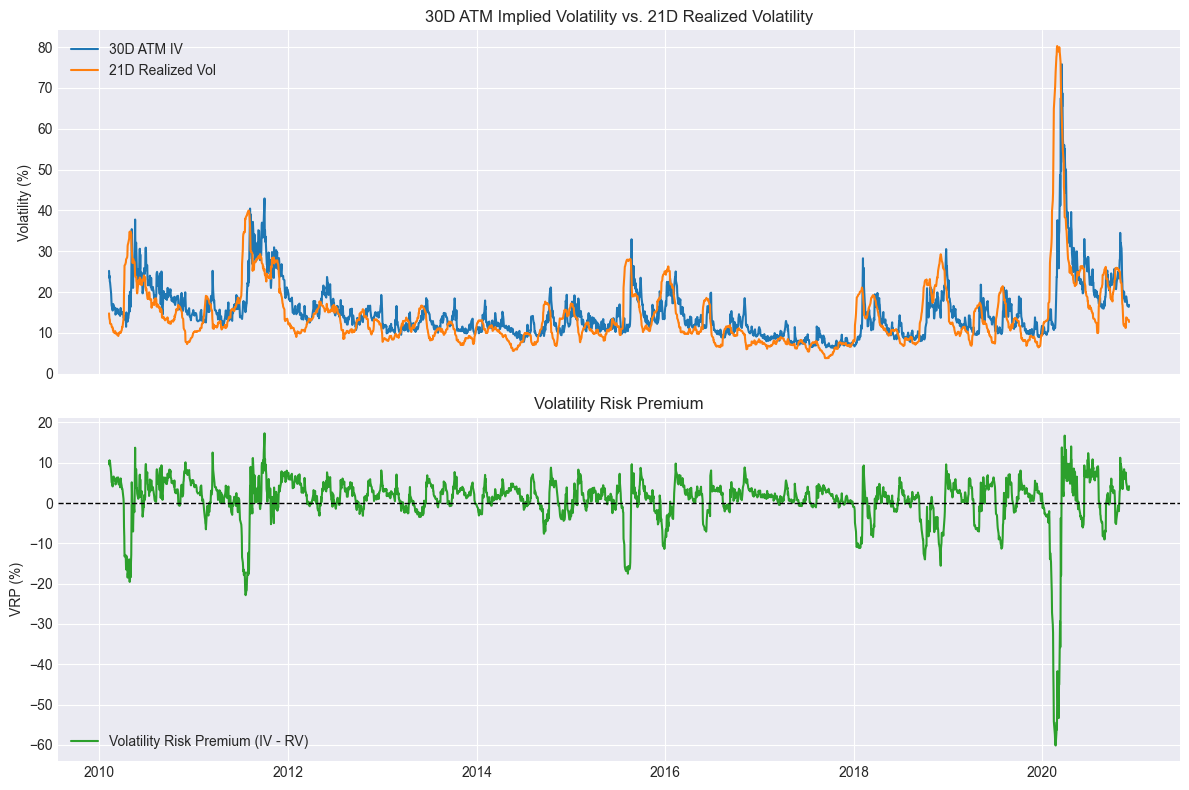

In [26]:
ph.plot_vrp(vol_df["iv_atm"], vol_df["rv"], vol_df["vrp"])

During calm markets, the VRP is typically positive, whereas during crashes (e.g., the COVID-19 lockdown) realized volatility can exceed implied volatility when the market fails to anticipate the shock. It migth sugguest that a strategy consiting in selling preniums can be profitabel over the long run. 

## **3.1 Stylized facts 3: VRP has fat-tails and skewed distribution**

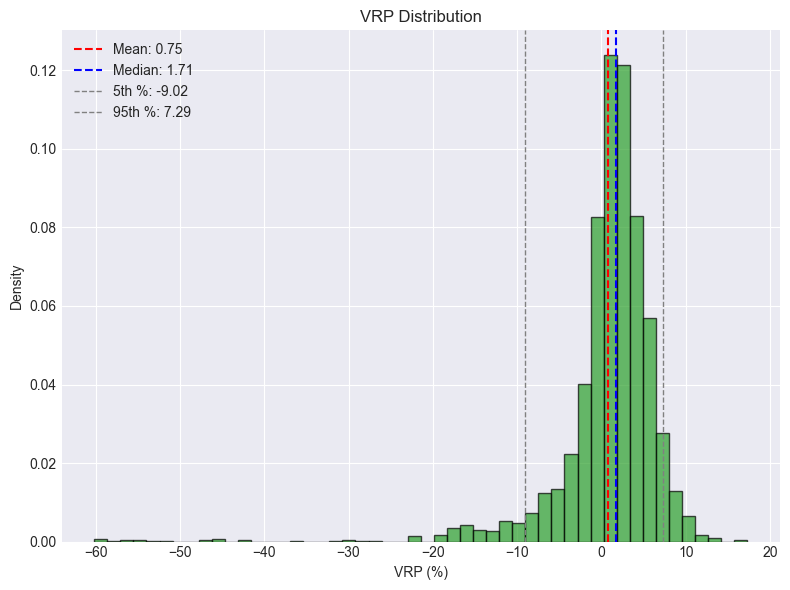

In [27]:
ph.plot_vrp_hist(vol_df["vrp"])

As you can see the VRP is positive in average but the presence how large left tails make its mean much less tha its median.
Thus excessive care msut be given to short vol strategies as they might be mostly mostly proftable but large blow ups can erode all prfoits accumulated over the years.
Thus the use of tail-risk filters like VIX Terme STructure, VVIX are essential to not avoid those large losess to materiazliee.

## **3.1 Stylised Fact 4 – VRP is Regime-Dependent**

The distribution of the Variance Risk Premium is **not stationary**.  
It shifts dramatically across volatility regimes:

- In **calm / low-volatility regimes**, VRP is usually positive and stable.  
- In **moderate / elevated volatility**, VRP often becomes larger (IV rises faster than RV).  
- In **stress / panic regimes**, VRP can remain **negative for extended periods**, and short-vol strategies become unprofitable.

This regime dependence is one of the key motivations for using **filters** and **regime-based sizing** in a VRP strategy.

In [28]:
bins = [-np.inf, 15, 20, 30, np.inf]

labels = [
    "15 <= VIX",
    "15 < VIX <= 20",
    "20 < VIX <= 30",
    "VIX >= 30",
]

vol_df["vix_bucket"] = pd.cut(vol_df["VIX"], bins=bins, labels=labels)

grouped = vol_df.groupby("vix_bucket", observed=True)["vrp"].agg(
    ["mean", "std", "max", "min", "skew", "count"]
)
grouped

,mean,std,max,min,skew,count
vix_bucket,,,,,,
15 <= VIX,-0.018500,5.009336,5.902433,-59.098562,-5.778822,1173
15 < VIX <= 20,0.902213,6.120893,8.757357,-60.168488,-3.823167,842
20 < VIX <= 30,1.690643,7.096890,12.531410,-56.983512,-3.745067,502
VIX >= 30,2.401942,11.979656,17.310865,-53.347527,-3.104832,184


On the full `2010–2020` sample, the typical size of the VRP and its variability both increase with VIX. 

- Extremely low-volatility regimes (VIX < 15) offer almost no premium.
- Intermediate regimes (20 < VIX ≤ 30) show the best risk–reward (high mean VRP relative to its dispersion). 
- Very high VIX(≥ 30) offers the richest VRP on average, but with much higher volatility and tail risk.

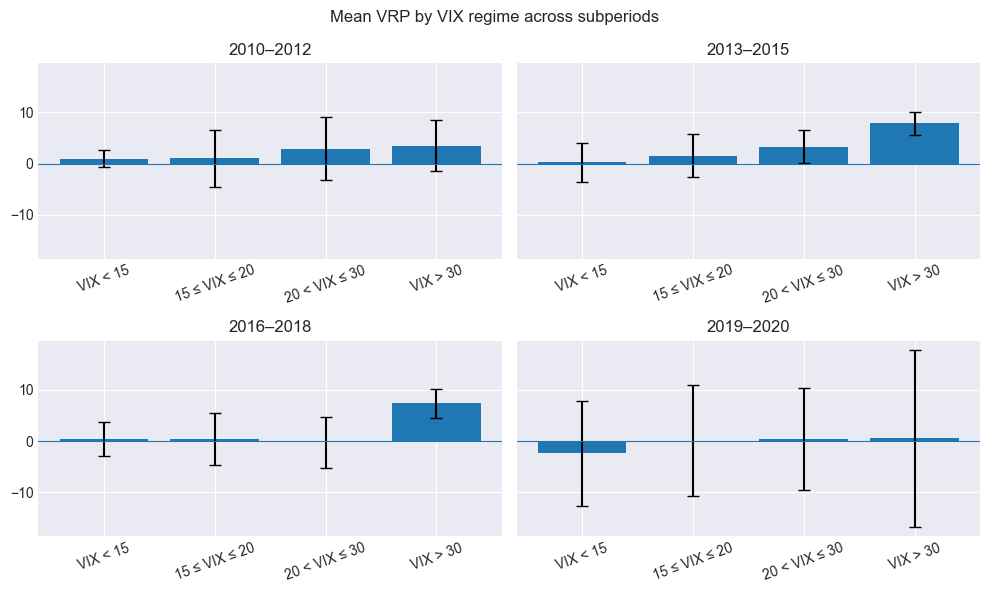

In [33]:
ph.plot_vrp_by_vix_bucket_subperiods(vol_df)

However, the subperiod breakdown shows that these bucket-level averages are
not stable over time:

- `2010–2015`: VRP is positive in most VIX regimes and increases with VIX.
- `2016–2018`: low-VIX buckets are close to flat; only VIX > 30 shows a strong
  positive premium.
- `2019–2020`: low-VIX regimes become outright negative, and even higher-VIX
  buckets show small means with very large dispersion.

In other words, the relation between VIX level and VRP has **shifted over
time**. The unconditional statistics hide this change. 

In [30]:
butterfly = pd.read_csv(DATA_PROC / "BFLY_History.csv", index_col=0, parse_dates=True)
butterfly = butterfly["BFLY"].squeeze()
butterfly.index.name = "date"

In [31]:
butterfly

date
1986-06-20    100.00
1986-06-23    100.00
1986-06-24    100.00
1986-06-25    100.00
1986-06-26    100.00
               ...  
2025-11-21    400.03
2025-11-24    398.57
2025-11-25    397.27
2025-11-26    395.91
2025-11-28    394.92
Name: BFLY, Length: 9933, dtype: float64